In [1]:
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
sys.path.append("..")
import spasne

### Loading data and transforming it to AnnData object

In [2]:
df_data = pd.read_csv('./data/mouse_VisualCortex1207_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=None) 
df_pixel = pd.read_csv('./data/mouse_VisualCortex1207_pixels.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_labels = pd.read_csv('./data/mouse_VisualCortex1207_labels.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_PCs = pd.DataFrame(list(df_data.columns), index = df_data.columns, columns =['PCs'] )
cluster_label = list(df_labels['LayerName'])
adata = sc.AnnData(X = df_data, obs = df_pixel, var = df_PCs)
adata.obs['gt'] = cluster_label

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Visualizing spots from image

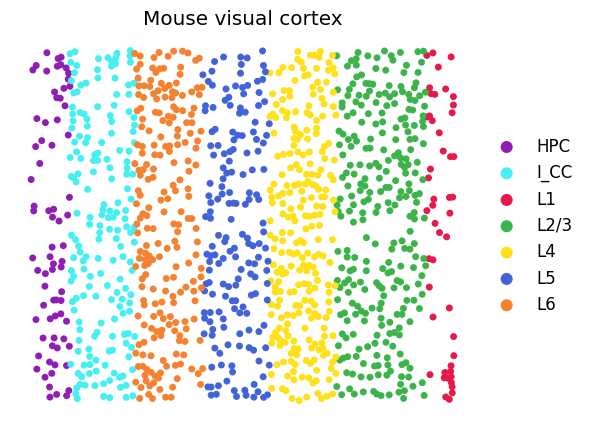

In [3]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
sz = 100

plot_color=['#911eb4', '#46f0f0','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',  '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Mouse visual cortex'
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_yaxis()


### Calculating data distances and spatial distances

In [4]:
N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X, X)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_spatial = scipy.spatial.distance.squareform(dist_sq)
df_pixel = df_pixel.astype(np.float64)

### Performing t-SNE embedding

In [5]:
tsne_pos = spasne.run_spasne(df_data, alpha = 0.0, randseed = 5)
dist_sq = euclidean_distances(tsne_pos, tsne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
# Measuring gene expression presrvation
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
# Measuring spatial structure presrvation
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
# Calculating silhouette score based on ground truth annotations
ss = sklearn.metrics.silhouette_score(tsne_pos,cluster_label)
quant_eval_tsne = [r1,r2,ss]
adata.obs['tsne_pos_x'] = tsne_pos[:,0]
adata.obs['tsne_pos_y'] = tsne_pos[:,1]


### Visualizing spots from t-SNE embedding

(-8.850008179568091, 9.101123546049841, -12.2018123164647, 9.782558395185754)

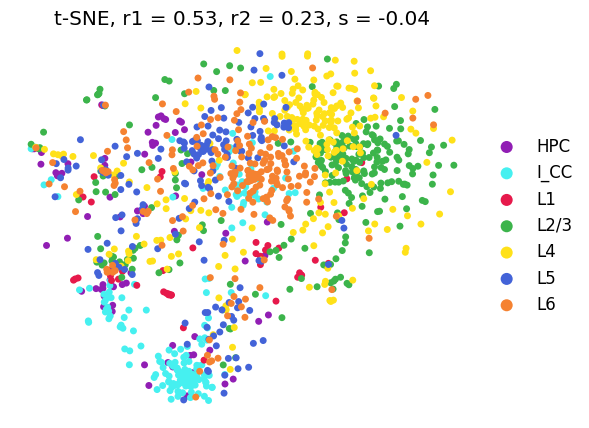

In [6]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 't-SNE, ' + 'r1 = %.2f'% quant_eval_tsne[0] + ', r2 = %.2f'%quant_eval_tsne[1] + ', s = %.2f'%quant_eval_tsne[2]
ax=sc.pl.scatter(adata,alpha=1,x="tsne_pos_x",y="tsne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')


### Performing SpaSNE embedding

In [7]:
alpha = 14
beta = 3
spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta, randseed = 5)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label)
quant_eval_spasne = [r1,r2,ss]
adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

### Visualizing spots from SpaSNE embedding

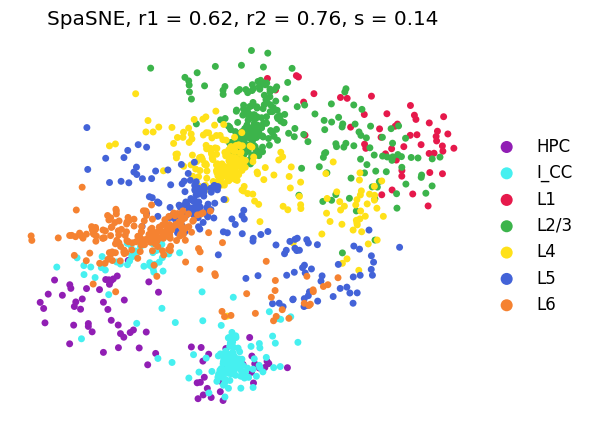

In [8]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, ' + 'r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] + ', s = %.2f'%quant_eval_spasne[2]
ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_xaxis()


### Showing expression values of marker genes

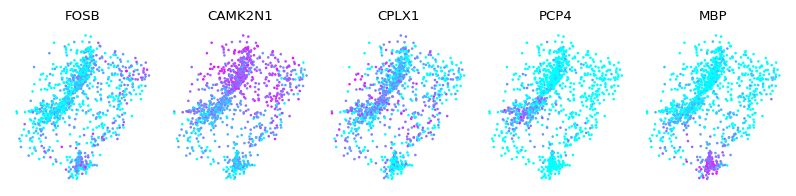

In [9]:
df_data = pd.read_csv('./data/mouse_VisualCortex1207_data.csv',sep=",",header=0,na_filter=False,index_col=0) 
gene_expr = np.array(df_data)
gene_names = np.array(df_data.columns)
gene_names = np.array([gene.upper() for gene in gene_names])
select_genes = ['FOSB','CAMK2N1','CPLX1','PCP4','MBP']
matplotlib.rcParams['font.size'] = 8.0
gene_num = 5
fig, axes = plt.subplots(1, gene_num, figsize=(8,2))
sz = 3
x = spasne_pos[:,0]
y = spasne_pos[:,1]

for col in range(gene_num):
    g = select_genes[col]
    clrs = gene_expr[:,gene_names== g][:,0]
    clrs = (clrs-min(clrs))/(max(clrs) - min(clrs))
    vmin = 0
    vmax = max(clrs)
    ax_temp = axes[col]
    im = ax_temp.scatter(x, y, s=sz, c=clrs, cmap='cool',marker = '.',alpha = 1, vmin = vmin, vmax = vmax)
    ax_temp.set_title(g)
    ax_temp.axis('off')
    ax_temp.axes.invert_xaxis()

fig.tight_layout()
# fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)